# Resampling for regression (resreg) tutorial
## Tutorial 03 - REBAGG: Resampled bagging

In this tutorial, we will combine the resampling techniques presented in the previous tutorial (02) with bagging to improve the predictive performance on the California housing dataset. Bagging involves training multiple weak learners independently on bootstrap samples of the dataset, and then combining the individual outputs to obtain a more accurate prediction. With the resampled bagging algorithm (REBAGG), each base learner is trained on a separately resampled subset of the dataset, and the outputs of the base learners are averaged to generate a final prediction.

### Import libraries and dataset

In [1]:
import numpy as np
import seaborn as sns
import itertools
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing as dataset
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '..')
import resreg

### Retrieve dataset

In [2]:
data = dataset()
X = data.data
y = data.target
np.random.seed(seed=0)
sample = np.random.choice(range(len(y)), 500)
X, y = X[sample,:], y[sample]

### Steps in the REBAGG algorithm
1. For each of ${m}$ base learners, ${s}$ samples are drawn from the training dataset.
2. If *size_method* is *balance*, then equal number of samples (${s}$/2) are randomly drawn from the rare and normal domains. Otherwise, if *size_method* is *variation*, ${s \times p}$ and ${s \times (1-p)}$ samples are randomly drawn from the rare and normal domains, respectively. ${p}$ is randomly chosen from (1/3, 2/5, 1/2, 2/5, 2/3).
3. If the rare domain is smaller than ${s}$/2 (or ${s \times p}$, if *size_method* is *variation*), then the rare domain is oversampled using a selected *sample_method* (random oversampling, SMOTER, or Gaussian noise) before drawing samples.
4. Alternatively, if *sample_method* is *wercs*, the relevance values are used as weights to resample the dataset before selecting ${s}$ samples for fitting ${m}$ base learners.
5. The ${m}$ base learners are fitted on the resampled datasets.
6. Each base learner is applied to the test data and the average of the ${m}$ predictions is returned as the final output.

### REBAGG with random oversampling (REBAGG-RO)
The rare domain is oversampled by duplicating randomly selected values before fitting base learners. We will determine the best hyperparameters by a grid search.

In [3]:
# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
params = list(itertools.product(sizes, size_methods))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method = param
    
    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function
        
        # Fit rebagg ensemble using random oversampling to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                   sample_method='random_oversample', size_method=size_method, random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                            relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
        
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) 
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5) # standard error
    # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

__View performance of best hyperparameters__

Best parameters: 
      s=0.5, size_method=variation


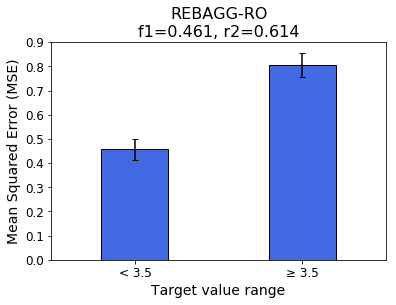

In [4]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
bins=[3.5]
ticks_font = {'size':'12'}
label_font = {'size':'14'}
title_font = {'size':'16'}

def plotPerformance(msebin, msebinerr, f1, r2, title):
    plt.bar(range(2), msebin, yerr=msebinerr, width=0.4, capsize=3, color='royalblue',
           linewidth=1, edgecolor='black')
    plt.xlim(-0.5, len(bins)+0.5)
    plt.xticks(range(2), ['< {0}'.format(bins[0]), '≥ {0}'.format(bins[0])], **ticks_font)
    plt.yticks(**ticks_font)
    plt.ylabel('Mean Squared Error (MSE)', **label_font)
    plt.xlabel('Target value range', **label_font)
    title = title + '\nf1={0}, r2={1}'.format(round(f1,3), round(r2,3))
    plt.title(title, **title_font)
    plt.show()
    plt.close()

plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-RO')

# Save results
CACHE = joblib.load('cache.pkl')
CACHE['REBAGG-RO'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      



### REBAGG with SMOTER (REBAGG-SMOTER)
The rare domain is oversampled by interpolation with the SMOTER method before fitting base learners.

In [5]:
# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
ks = [5, 10, 15] # Number of nearest numbers to select for interpolation
params = list(itertools.product(sizes, size_methods, ks))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method, k = param
    
    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function
        
        # Fit rebagg ensemble using SMOTER to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                    sample_method='smoter', size_method=size_method, random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                            relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
    
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) # average over 5fold cross validation
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5) # standard error
    
    # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

__View performance of best hyperparameters__

Best parameters: 
      s=0.5, size_method=balance, k=15


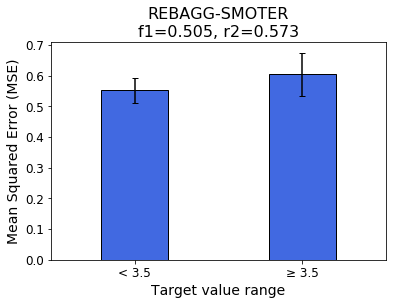

In [6]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}, k={bestparams[2]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-SMOTER')

# Save results
CACHE['REBAGG-SMOTER'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      

### REBAGG with introduction of Gaussian noise (REBAGG-GN)
The rare domain is oversampled by introduction of Gaussian noise before fitting the base learners

In [7]:
# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
deltas = [0.01, 0.1, 0.5] # magnitude of Gaussian noise
params = list(itertools.product(sizes, size_methods, deltas))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method, delta = param
    
    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function
        
        # Fit rebagg ensemble using SMOTER to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                    sample_method='gaussian', size_method=size_method, delta=delta,
                    random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                            relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
    
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) # average over 5fold cross validation
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5) # standard error
    # Save grid search results   
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

__View performance of best hyperparameters__

Best parameters: 
      s=0.5, size_method=balance, delta=0.01


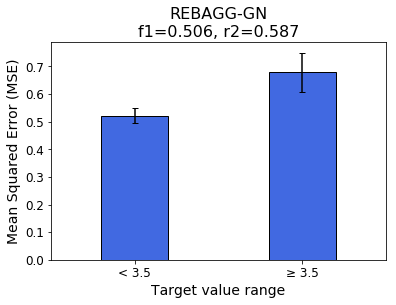

In [8]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}, delta={bestparams[2]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-GN')

# Save results
CACHE['REBAGG-GN'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      

### REBAGG with WERCS (REBAGG-WERCS)

The data is resampled with the WERCS method (sampled using the relevance as weights), before fitting each base learner. Gaussian noise may be added to the resampled data by specifying *sample_method* as *wercs-gn*.

In [9]:
# Hyperparameters
sizes = [0.25, 0.5]
overs = [0.25, 0.5, 0.75]
unders = [0.25, 0.5, 0.75]
deltas = [0.1, 0.5]

params = list(itertools.product(sizes, overs, unders)) + \
        list(itertools.product(sizes, overs, unders, deltas))

# Grid search
r2store, f1store, msebinstore = [], [], []  # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    if len(param) == 3:
        sample_method = 'wercs' # wercs without gaussian noise
        s, over, under = param
    else:
        sample_method = 'wercs-gn'  # wercs with gaussian noise
        s, over, under, delta = param
    
    # Fivefold cross valdation (fit ensemble and evaluate performance on testing set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], []  # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=3.5)
        
        # Fit Rebagg ensemble
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0) # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg)
        rebagg.fit(X_train, y_train, relevance=relevance, sample_method=sample_method, 
                   over=over, under=under, delta=delta, random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        relTrue = resreg.sigmoid_relevance(y_test, cl=None, ch=3.5)
        relPred = resreg.sigmoid_relevance(y_pred, cl=None, ch=3.5)
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=relTrue,
                             relevance_pred=relPred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
    
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                            np.std(msebins, axis=0)/np.sqrt(5)  # standard error
    
    # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

__View performance of best hyperparameters__

Best parameters: 
      s=0.5, over=0.75, under=0.75, delta=0.5


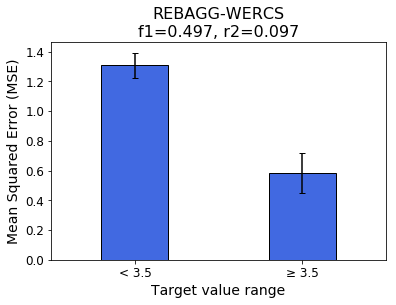

In [10]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, over={bestparams[1]}, under={bestparams[2]}, delta={bestparams[3]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-WERCS')

# Save results
CACHE['REBAGG-WERCS'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      

### Plot performance of all resampling strategies
Let us visualize the effect of resampling strategies on the F1 score, mean squared error (MSE) and r${^2}$ value.

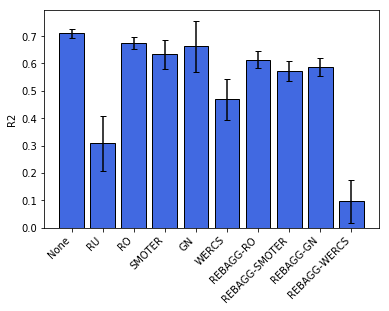

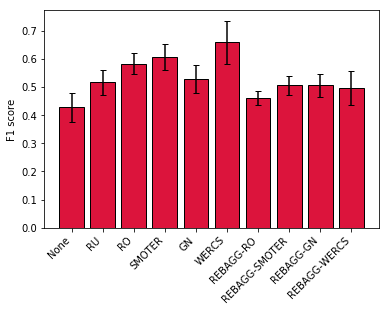

<function matplotlib.pyplot.show(*args, **kw)>

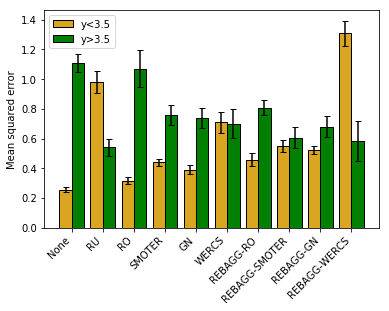

In [11]:
# Data from CACHE
r2s = [val[0] for val in CACHE.values()]
r2errs = [val[3] for val in CACHE.values()]
f1s = [val[1] for val in CACHE.values()]
f1errs = [val[4] for val in CACHE.values()]
msebins = np.asarray([val[2] for val in CACHE.values()])
msebinerrs = np.asarray([val[5] for val in CACHE.values()])
keys = CACHE.keys()

# Plot r2
plt.bar(range(len(keys)), r2s, yerr=r2errs, capsize=3, color='royalblue',
       linewidth=1, edgecolor='black')
_ = plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
plt.ylabel('R2')
plt.show()

# Plot F1
plt.bar(range(len(keys)), f1s, yerr=f1errs, capsize=3, color='crimson',
       linewidth=1, edgecolor='black')
_ = plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
plt.ylabel('F1 score')
plt.show()

# Plot MSE over bins
plt.bar(np.arange(len(keys))-0.2, msebins[:,0], width=0.4, yerr=msebinerrs[:,0],
       capsize=3, color='goldenrod', linewidth=1, edgecolor='black', label='y<3.5')
plt.bar(np.arange(len(keys))+0.2, msebins[:,1], width=0.4, yerr=msebinerrs[:,1],
       capsize=3, color='green', linewidth=1, edgecolor='black', label='y>3.5')
_ = plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
plt.ylabel('Mean squared error')
plt.legend()
plt.show

### Summary
1. Regression on datasets that have normally distributed target values can lead to models that perform poorly on rare extreme values.
2. If the extreme rare region of target values is of particular importance to the user, overall performance metrics like correlation coefficient (r) may be misleading since they are biased towards abundant values. Hence, it is important to use metrics that capture the performance on the important rare values. 
3. The user can evaluate overall performance metrics (e.g., r and r${^2}$) on a uniformly distributed test set, so that the performance on rare values is adequately captured. The F1 score may also be a practical metric.
4. Resampling strategies that modify the distribution of the data can improve the predictive performance on rare values.
5. Several resampling strategies can be implemented with the resreg module, including random undersampling, random oversampling, SMOTER, introduction of Gaussian noise, WERCS, and REBAGG. REBAGG combines ensemble learning (bagging) with the resampling methods.
6. There are hyperparameters for each resampling strategy that affect the performance. It may be necessary to determine the optimal hyperparameter combination. The user will need to choose an appropriate evaluation metric (F1 score, r${^2}$ on a uniformly distributed test set, etc.) for hyperparameter optimization.
7. Regardless of whether resampling strategies are applied, it is imperative that the user evaluate the predictive performance across the range of target values (e.g. MSE over bins) to ascertain that the regressor does not perform very poorly on extreme values.


### References
1. Gado, J.E., Beckham, G.T., and Payne, C.M. (2020). _Improving enzyme optimum temperature prediction with resampling strategies and ensemble learning_.

2. Branco, P., Torgo, L., and Ribeiro, R.P. (2019). _Pre-processing approaches for imbalanced distributions in regression_.

3. Torgo, L., Branco, P., Ribeiro, R.P., et al (2015). _Resampling strategies for regression_.